In [1]:
!pip install --quiet -U bigartm pymorphy2 pyLDAvis


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import re

from matplotlib import gridspec
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from tqdm.notebook import tqdm

import artm
import pymorphy2
import torch
from torch.utils.tensorboard import SummaryWriter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

In [3]:
data = pd.read_csv('lenta-ru-proccess.csv')

In [4]:
data = data.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [5]:
data

,text,tags,len,date
0,"сайт "" единый россия "" рамка подготовка переме...",Все,1338,27-05-2008
1,понедельник трое активист британский правозащи...,Все,1210,28-02-2005
2,обмен тело израильский военнослужащий эхуд гол...,Все,1753,16-07-2008
3,украина рассчитывать получить очередной транш ...,Госэкономика,1282,01-03-2017
4,римский аэропорт фьюмичино сотрудник служба бе...,Все,743,21-07-2007
...,...,...,...,...
431637,роспотребнадзор приостановить ввоз территория ...,Бизнес,639,26-04-2017
431638,подозревать отравление газировка 20 человек це...,Следствие и суд,2457,25-06-2019
431639,эксперт радиологический лаборатория университе...,Все,1336,24-08-2012
431640,россия откладывать возобновление авиасообщение...,Россия,1229,17-11-2019


In [6]:
def prepare_data(model_name, func, data, batch_size=2048):
    filename_train = f'vw_data/{model_name}/texts_train.vw.txt'
    filename_valid = f'vw_data/{model_name}/texts_valid.vw.txt'
    
    with open(filename_train, 'w') as fout_train:
        with open(filename_valid, 'w') as fout_valid:
            y_train, y_valid = func(data, fout_train, fout_valid)

    with open(f'vw_data/{model_name}/y_train.vw.txt', 'w') as f:
        f.write('\n'.join(y_train))

    with open(f'vw_data/{model_name}/y_valid.vw.txt', 'w') as f:
        f.write('\n'.join(y_valid))

    bv_train = artm.BatchVectorizer(
        data_path=filename_train,
        data_format='vowpal_wabbit',
        batch_size=batch_size, 
        target_folder=f'vw_batches/{model_name}/batches_train')
    
    bv_test = artm.BatchVectorizer(
        data_path=filename_valid,
        data_format='vowpal_wabbit',
        batch_size=batch_size, 
        target_folder=f'vw_batches/{model_name}/batches_valid')

    dictionary = artm.Dictionary()
    dictionary.gather(data_path=f'vw_batches/{model_name}/batches_train')

    return dictionary, bv_train, bv_test, y_train, y_valid

In [32]:
def create_model(num_topics, dictionary, class_ids, scores, regularizers=[]):
    model = artm.ARTM(
        num_topics=num_topics,
        dictionary=dictionary,
        class_ids=class_ids)

    for score in scores:
        model.scores.add(score)

    for regularizer in regularizers:
        model.regularizers.add(regularizer)

    return model

In [8]:
def fit_model(model, bv_train, n_iterations=10, num_collection_passes=1):
    iterator = tqdm(range(n_iterations))
    for i in iterator:
        model.fit_offline(bv_train, num_collection_passes=num_collection_passes)

In [9]:
def estimate_model(model, bv_train, bv_test, y_train, y_valid):
    X_train_pd, X_train = model.transform(bv_train), []
    for i in tqdm(range(len(y_train))):
        X_train.append(X_train_pd[i].values)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_train, y_train = shuffle(X_train, y_train)

    X_train = X_train[:40000]
    y_train = y_train[:40000]

    classifier = RandomForestClassifier(n_estimators=10)
    classifier.fit(X_train, y_train)

    X_valid_pd, X_valid = model.transform(bv_test), []
    for i in tqdm(range(len(y_valid))):
        X_valid.append(X_valid_pd[i].values)

    pred = classifier.predict(X_valid)

    return classification_report(y_valid, pred, zero_division=1)

In [10]:
def show_model_metric(model, metric_name):
    plt.plot(model.score_tracker[metric_name].value, label=metric_name)

    plt.legend(loc='best')

    plt.xlabel('iteration')
    plt.ylabel('score')
    plt.show()

# Simple

In [11]:
model_name = 'simple'

In [12]:
def func_simple(data, fout_train, fout_valid):
    counter_train = 0
    counter_valid = 0

    y_train = []
    y_valid = []

    reg = re.compile(r'\W+')
    for i in tqdm(range(len(data))):
        text = (reg.sub(' ', data.loc[i]['text']).strip()).split()

        if len(text) > 100:
            date = data.loc[i]['date'].split('-')[-1].lower().strip()
            if (i + 1) % 100 != 0:
                fout_train.write('doc_{} {}\n'.format(counter_train, ' '.join(text)))
                counter_train += 1
                y_train.append(date) 
            else:
                fout_valid.write('doc_{} {}\n'.format(counter_valid, ' '.join(text)))
                counter_valid += 1
                y_valid.append(date)

    return y_train, y_valid

In [13]:
dictionary, bv_train, bv_test, y_train, y_valid = prepare_data(model_name, func_simple, data)

  0%|          | 0/431642 [00:00<?, ?it/s]

In [14]:
# model = artm.load_artm_model(f'model/{model_name}')

# model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)

In [15]:
model = create_model(128, dictionary, {'@default_class': 1.0}, (artm.PerplexityScore(name='perplexity', dictionary=dictionary),))

In [16]:
fit_model(model, bv_train)

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# model.dump_artm_model(f'model/{model_name}')

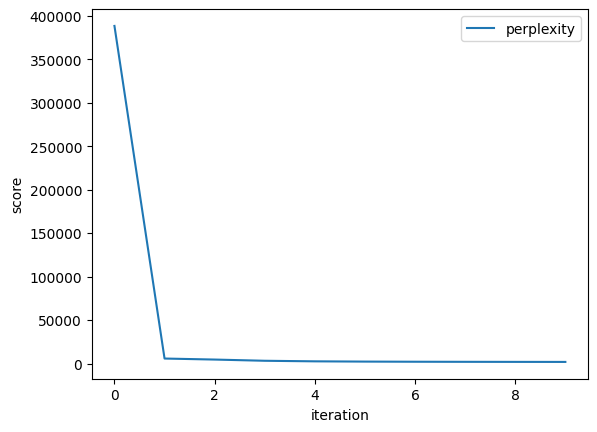

In [18]:
show_model_metric(model, 'perplexity')

In [19]:
report = estimate_model(model, bv_train, bv_test, y_train, y_valid)

  0%|          | 0/326899 [00:00<?, ?it/s]

  0%|          | 0/3281 [00:00<?, ?it/s]

In [20]:
print(report)

              precision    recall  f1-score   support

        1999       0.00      0.00      1.00        10
        2000       0.02      0.03      0.02        34
        2001       0.00      0.00      1.00        62
        2002       0.05      0.05      0.05        59
        2003       0.11      0.11      0.11        74
        2004       0.04      0.05      0.04        84
        2005       0.05      0.07      0.06       113
        2006       0.02      0.03      0.02       115
        2007       0.07      0.08      0.07       131
        2008       0.08      0.08      0.08       180
        2009       0.10      0.13      0.11       204
        2010       0.09      0.11      0.10       164
        2011       0.11      0.12      0.11       198
        2012       0.08      0.08      0.08       203
        2013       0.05      0.05      0.05       187
        2014       0.10      0.08      0.09       158
        2015       0.11      0.09      0.10       199
        2016       0.12    

# Modality

In [21]:
model_name = 'modality'

In [22]:
def func_modality(data, fout_train, fout_valid):
    counter_train = 0
    counter_valid = 0

    y_train = []
    y_valid = []

    reg = re.compile(r'\W+')
    for i in tqdm(range(len(data))):
        text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
        label = data.loc[i]['tags']

        if len(text) > 100:
            date = data.loc[i]['date'].split('-')[-1].lower().strip()
            if (i + 1) % 100 != 0:
                fout_train.write('doc_{} {} |@tags class_{}\n'.format(counter_train, ' '.join(text), label))
                counter_train += 1
                y_train.append(date) 
            else:
                fout_valid.write('doc_{} {} |@tags class_{}\n'.format(counter_valid, ' '.join(text), label))
                counter_valid += 1
                y_valid.append(date)

    return y_train, y_valid

In [23]:
dictionary, bv_train, bv_test, y_train, y_valid = prepare_data(model_name, func_modality, data)

  0%|          | 0/431642 [00:00<?, ?it/s]

In [24]:
# model = artm.load_artm_model(f'model/{model_name}')

# model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)

In [25]:
model = create_model(
    128,
    dictionary,
    {'@default_class': 1.0, '@tags': 10.0},
    (
        artm.PerplexityScore(name='perplexity', dictionary=dictionary),
        artm.SparsityPhiScore(name='sparsity', class_id='@tags'),
    ))

In [26]:
fit_model(model, bv_train, n_iterations=15)

  0%|          | 0/15 [00:00<?, ?it/s]

In [27]:
# model.dump_artm_model(f'model/{model_name}')

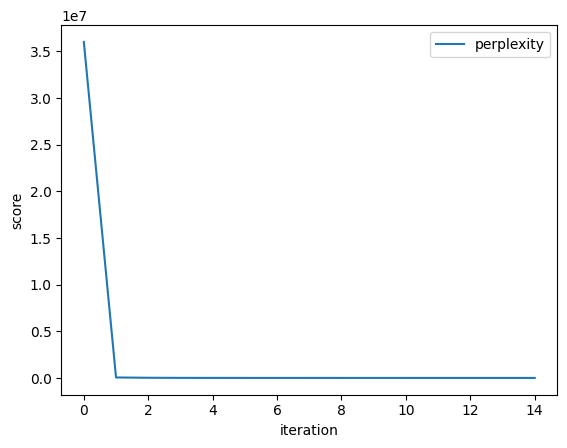

In [28]:
show_model_metric(model, 'perplexity')

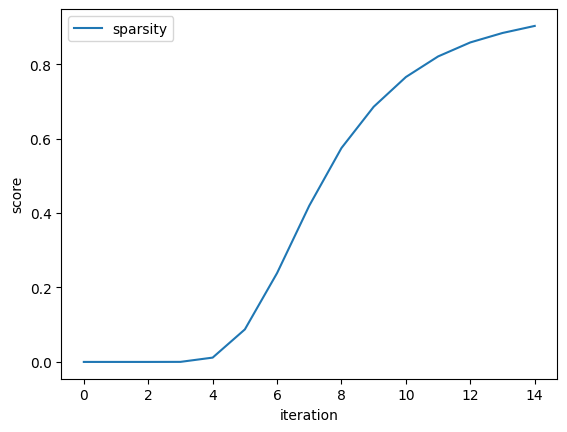

In [29]:
show_model_metric(model, 'sparsity')

In [30]:
report = estimate_model(model, bv_train, bv_test, y_train, y_valid)

  0%|          | 0/326899 [00:00<?, ?it/s]

  0%|          | 0/3281 [00:00<?, ?it/s]

In [31]:
print(report)

              precision    recall  f1-score   support

        1999       0.00      0.00      1.00        10
        2000       0.00      0.00      1.00        34
        2001       0.04      0.03      0.04        62
        2002       0.01      0.02      0.02        59
        2003       0.05      0.04      0.04        74
        2004       0.08      0.10      0.09        84
        2005       0.08      0.09      0.08       113
        2006       0.03      0.03      0.03       115
        2007       0.11      0.11      0.11       131
        2008       0.15      0.18      0.17       180
        2009       0.14      0.20      0.16       204
        2010       0.10      0.12      0.11       164
        2011       0.15      0.15      0.15       198
        2012       0.13      0.12      0.13       203
        2013       0.15      0.17      0.16       187
        2014       0.06      0.06      0.06       158
        2015       0.12      0.12      0.12       199
        2016       0.20    

# Regularizer

In [33]:
model_name = 'regularizer'

In [35]:
dictionary, bv_train, bv_test, y_train, y_valid = prepare_data(model_name, func_modality, data)

  0%|          | 0/431642 [00:00<?, ?it/s]

In [36]:
model = create_model(
    128,
    dictionary,
    {'@default_class': 1.0, '@tags': 10.0},
    (
        artm.PerplexityScore(name='perplexity', dictionary=dictionary),
        artm.SparsityPhiScore(name='sparsity', class_id='@tags'),
    ),
    (
        artm.SmoothSparsePhiRegularizer(name='sparse_phi', tau=-0.5),
    ))

In [37]:
fit_model(model, bv_train, n_iterations=15)

  0%|          | 0/15 [00:00<?, ?it/s]

In [43]:
# model.dump_artm_model(f'model/{model_name}')

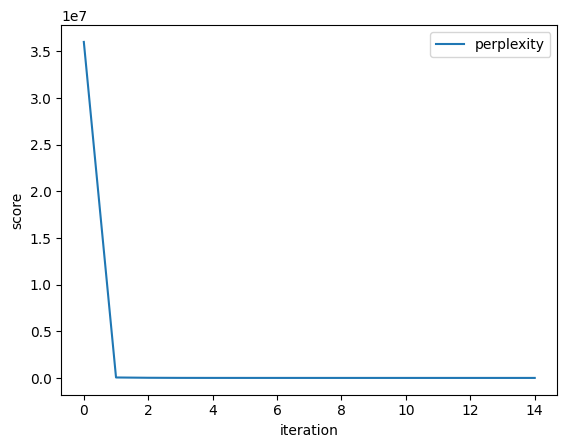

In [39]:
show_model_metric(model, 'perplexity')

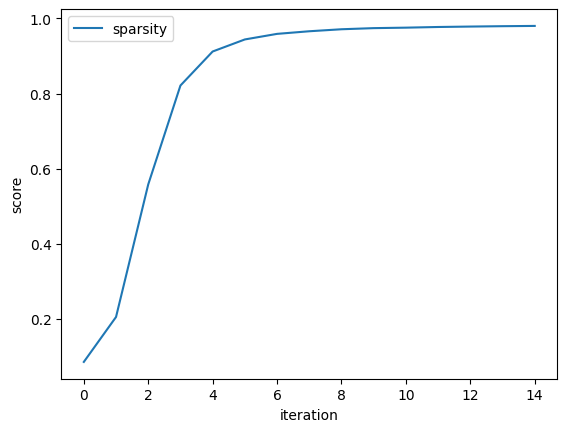

In [40]:
show_model_metric(model, 'sparsity')

In [41]:
report = estimate_model(model, bv_train, bv_test, y_train, y_valid)

  0%|          | 0/326899 [00:00<?, ?it/s]

  0%|          | 0/3281 [00:00<?, ?it/s]

In [42]:
print(report)

              precision    recall  f1-score   support

        1999       0.00      0.00      1.00        10
        2000       0.00      0.00      1.00        34
        2001       0.05      0.03      0.04        62
        2002       0.07      0.08      0.08        59
        2003       0.10      0.09      0.10        74
        2004       0.10      0.12      0.11        84
        2005       0.07      0.09      0.08       113
        2006       0.10      0.14      0.12       115
        2007       0.11      0.11      0.11       131
        2008       0.13      0.17      0.15       180
        2009       0.12      0.17      0.14       204
        2010       0.10      0.12      0.11       164
        2011       0.12      0.11      0.11       198
        2012       0.10      0.09      0.10       203
        2013       0.17      0.17      0.17       187
        2014       0.11      0.09      0.10       158
        2015       0.14      0.15      0.14       199
        2016       0.16    

# Years

In [58]:
model_name = 'years'

In [59]:
def func_years(data, fout_train, fout_valid):
    counter_train = 0
    counter_valid = 0

    y_train = []
    y_valid = []

    reg = re.compile(r'\W+')
    for i in tqdm(range(len(data))):
        text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
        label = data.loc[i]['date'].split('-')[-1].lower().strip()

        if len(text) > 100:
            date = label
            if (i + 1) % 100 != 0:
                fout_train.write('doc_{} {} |@years class_{}\n'.format(counter_train, ' '.join(text), label))
                counter_train += 1
                y_train.append(date) 
            else:
                fout_valid.write('doc_{} {} |@years class_{}\n'.format(counter_valid, ' '.join(text), label))
                counter_valid += 1
                y_valid.append(date)

    return y_train, y_valid

In [60]:
dictionary, bv_train, bv_test, y_train, y_valid = prepare_data(model_name, func_years, data)

  0%|          | 0/431642 [00:00<?, ?it/s]

In [61]:
model = create_model(
    128,
    dictionary,
    {'@default_class': 1.0, '@years': 10.0},
    (
        artm.PerplexityScore(name='perplexity', dictionary=dictionary),
        artm.SparsityPhiScore(name='sparsity', class_id='@years'),
    ),
    (
        artm.SmoothSparsePhiRegularizer(name='sparse_phi', tau=-0.5),
    ))

In [62]:
fit_model(model, bv_train, n_iterations=15)

  0%|          | 0/15 [00:00<?, ?it/s]

In [63]:
# model.dump_artm_model(f'model/{model_name}')

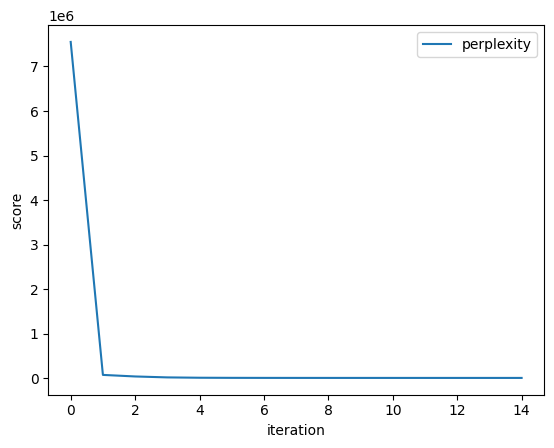

In [64]:
show_model_metric(model, 'perplexity')

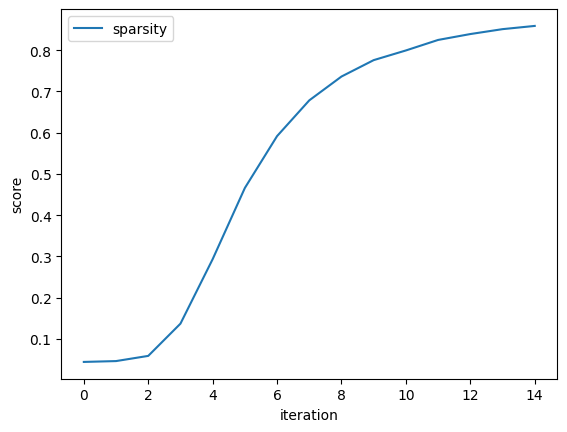

In [65]:
show_model_metric(model, 'sparsity')

In [66]:
report = estimate_model(model, bv_train, bv_test, y_train, y_valid)

  0%|          | 0/326899 [00:00<?, ?it/s]

  0%|          | 0/3281 [00:00<?, ?it/s]

In [67]:
print(report)

              precision    recall  f1-score   support

        1999       0.20      0.20      0.20        10
        2000       0.36      0.24      0.29        34
        2001       0.65      0.60      0.62        62
        2002       0.61      0.56      0.58        59
        2003       0.66      0.61      0.63        74
        2004       0.72      0.80      0.76        84
        2005       0.54      0.58      0.56       113
        2006       0.73      0.81      0.77       115
        2007       0.75      0.75      0.75       131
        2008       0.78      0.80      0.79       180
        2009       0.81      0.86      0.84       204
        2010       0.78      0.89      0.83       164
        2011       0.88      0.89      0.88       198
        2012       0.76      0.81      0.78       203
        2013       0.85      0.82      0.83       187
        2014       0.87      0.87      0.87       158
        2015       0.91      0.86      0.89       199
        2016       0.92    